# Classification on the Moons dataset with Passively Obtained Triplets
The Moons dataset is a simple dataset composed of two intertwined moons. Here, we show how we can use TripletBoost to learn a classifier for this single-label binary classification problem.

## Imports
We start by importing the TripletBoost class, the core of the method.

In [1]:
from tripletboost import TripletBoost

Then we choose an oracle from the module oracle. Here we settle for a passive oracle, that is an oracle which emulates the fact that triplets are passively obtained.

In [2]:
from tripletboost.oracle import OraclePassive

The oracle uses a distance function to generate the triplets. We use one provided by scikit-learn. By default this distance function is the Euclidean distance.

In [3]:
from sklearn.metrics.pairwise import pairwise_distances

To retrieve the dataset we use scikit-learn.

In [4]:
from sklearn.datasets import make_moons

Finally we import numpy for array manipulations and matplotlib.pyplot to visualize the results.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

## The Moons Dataset

We create $1000$ points shaped in two intertwined moons with some gaussian noise (standard deviation of $0.1$). We use $\frac{2}{3}$ of the data as a training set and the rest as a test set.

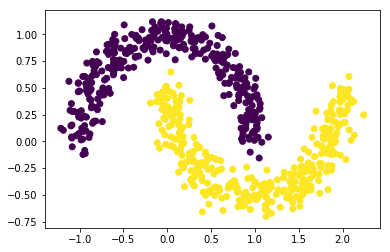

In [6]:
x,y = make_moons(n_samples=1000, shuffle=True, noise=0.1)
n = x.shape[0]

n_train = int(n*2/3)
n_test = n-n_train

x_train = x[:n_train,:]
y_train = y[:n_train]

x_test = x[n_train:,:]
y_test = y[n_train:]

plt.figure()
plt.scatter(x_train[:,0],x_train[:,1],c=y_train)
plt.show()

In order to plot the decision boundaries during the training process we need to add some more test data. This step is optional.

In [7]:
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 0.1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 0.1

xx,yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))

x_test_boundaries = np.c_[xx.ravel(), yy.ravel()]
n_test_boundaries = x_test_boundaries.shape[0]

x_test = np.vstack((x_test,x_test_boundaries))

## Initializing TripletBoost

### Oracle

To initialize TripletBoost we start by creating an oracle exhibiting two methods, from_pair and from_pair_test, that will be used to generate the triplets. Here we chose a passive oracle, that is an oracle that emulates the fact that the triplets are passively obtained. We assume that we have access to $10\%$ of the triplets and that $10\%$ of the triplets are noisy, that is they are randomly flipped.

In [8]:
oracle = OraclePassive(x_train,x_test,metric=pairwise_distances,proportion_triplets=0.1,proportion_noise=0.1)

### TripletBoost

We can now create the main TripletBoost object using the oracle defined above and the training labels. Note that y_train should be two-dimensional even in this single-label binary classification problem.

In [9]:
clf = TripletBoost(oracle,y_train.reshape(-1,1))

## Learning the Classifier

To learn a classifier we need to use the fit method from TripletBoost to perform a given number of rounds of boosting. We start with 100 rounds of boosting and we plot the current decision boundary.

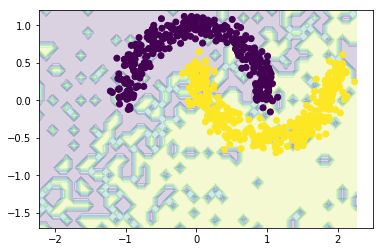

In [10]:
clf.fit(100)

labels_boundaries = np.array(clf.predict_top(n_test + n_test_boundaries))[n_test:]

Z = labels_boundaries.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, alpha=0.2)
plt.scatter(x_train[:,0],x_train[:,1],c=y_train)
plt.show()

The decision boundary is quite messy. This is expected since the number of boosting itereations is very small compared to the proporition of available triplets ($10\%$) and the degree of noise ($10\%$).

To counter this effect we need to increase the number of iterations.

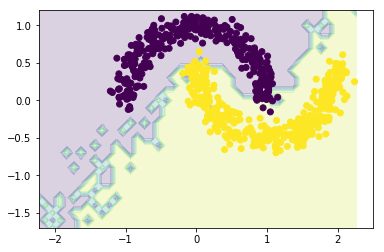

In [11]:
clf.fit(9900)

labels_boundaries = np.array(clf.predict_top(n_test + n_test_boundaries))[n_test:]

Z = labels_boundaries.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, alpha=0.2)
plt.scatter(x_train[:,0],x_train[:,1],c=y_train)
plt.show()

## Predicting the Test Labels

Now that we trained the classifier we can predict the test labels using the method predict_top. It predicts the most likely label for each test example. We then compute the prediction accuracy.

In [12]:
labels = clf.predict_top(n_test + n_test_boundaries)[:n_test]

accuracy = np.mean(y_test.ravel()==labels)

print("TripletBoost ran for {} iterations in {:.2f} seconds (including triplets generation). The test accuracy is {:.2f}.".format(clf.n_iterations,clf.time_elapsed,accuracy))

TripletBoost ran for 10000 iterations in 5.63 seconds (including triplets generation). The test accuracy is 0.99.
